<a href="https://colab.research.google.com/github/liviubobocu/eeml/blob/main/grammar_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer + RL with a Learnable CFG Prior (Google Colab, GPU)
Set Runtime → GPU and run the cells in order.


In [1]:
# (Optional) Force-install a specific CUDA wheel; Colab usually already has a working torch.
# !pip -q install --upgrade --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio

import torch, sys, os, platform
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch: 2.6.0+cu124 | CUDA available: False


In [27]:
# Imports, device, and helpers
import math, random, dataclasses
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

def set_seed(seed: int = 1337):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    torch.backends.cudnn.benchmark = True


Using device: cuda


In [38]:
# Tokenizer and minimal grammar state
class SimpleTokenizer:
    def __init__(self):
        self.itos = [str(i) for i in range(10)] + ['+', '-', '<eos>']
        self.stoi = {ch: i for i, ch in enumerate(self.itos)}
        self.eos_id = self.stoi['<eos>']
        self.vocab_size = len(self.itos)

class GrammarState:
    EXPECT_NUM = 0
    EXPECT_OP  = 1

    @staticmethod
    def compute_prefix_states(prefix_ids: torch.Tensor, tok: SimpleTokenizer) -> Dict[str, torch.Tensor]:
        B, T = prefix_ids.shape
        device = prefix_ids.device
        state_t = torch.zeros(B, T, dtype=torch.long, device=device)
        state = torch.full((B,), GrammarState.EXPECT_NUM, dtype=torch.long, device=device)
        for t in range(T):
            state_t[:, t] = state
            tok_t = prefix_ids[:, t]
            is_digit = (tok_t >= 0) & (tok_t <= 9)
            is_op = (tok_t == 10) | (tok_t == 11)
            state[is_digit] = GrammarState.EXPECT_NUM
            state[is_op]    = GrammarState.EXPECT_NUM
        return dict(state_t=state_t)


In [39]:
# Learnable grammar prior injecting head-wise attention bias
import torch
import torch.nn as nn
import torch.nn.functional as F

# Re-define ONLY the GrammarParams class with a safe build_log_prior
class GrammarParams(nn.Module):
    def __init__(self, vocab_size: int, num_heads: int, eos_id: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.eos_id = eos_id

        self.digit_logits = nn.Parameter(torch.zeros(10))  # 0..9
        self.op_logits    = nn.Parameter(torch.zeros(2))   # '+', '-'
        self.eos_logit    = nn.Parameter(torch.tensor(-3.0))  # small EOS tendency

        self.alpha_head_raw   = nn.Parameter(torch.randn(num_heads) * 0.1)
        self.head_cat_weights = nn.Parameter(torch.zeros(num_heads, 3))  # {DIGIT, OP, EOS}

    def get_alpha_heads(self):
        return F.softplus(self.alpha_head_raw)

    def build_log_prior(self, state_t: torch.Tensor, tok) -> torch.Tensor:
        """
        Safe assignment without mixing boolean mask and slices together.
        Returns [B, T, V] log-prior.
        """
        B, T = state_t.shape
        V = self.vocab_size
        device = state_t.device

        log_prior = torch.full((B, T, V), -20.0, device=device)

        # EXPECT_NUM → prefer digits + small EOS
        mask_num = (state_t == 0)  # GrammarState.EXPECT_NUM
        if mask_num.any():
            rows = log_prior[mask_num]        # [N, V]
            lp_digits = F.log_softmax(self.digit_logits, dim=-1)  # [10]
            rows[:, :10] = lp_digits          # broadcast across N rows
            rows[:, self.eos_id] = self.eos_logit

        # EXPECT_OP → prefer operators, discourage digits/EOS
        mask_op = (state_t == 1)  # GrammarState.EXPECT_OP
        if mask_op.any():
            rows = log_prior[mask_op]         # [N, V]
            lp_ops = F.log_softmax(self.op_logits, dim=-1)  # [2]
            rows[:, 10:12] = lp_ops
            rows[:, :10]   = -20.0
            rows[:, self.eos_id] = -20.0

        return log_prior

    # The rest of the class stays the same (attention bias)
    @staticmethod
    def _key_categories(prefix_ids: torch.Tensor, eos_id: int):
        """
        Return [B, T, 3] one-hots for {DIGIT, OP, EOS} using broadcasting
        (no boolean+slice mixing).
        """
        B, T = prefix_ids.shape
        dev = prefix_ids.device

        cats = torch.zeros(B, T, 3, device=dev, dtype=torch.float32)

        is_digit = ((prefix_ids >= 0) & (prefix_ids <= 9)).float()
        is_op    = ((prefix_ids == 10) | (prefix_ids == 11)).float()
        is_eos   = (prefix_ids == eos_id).float()

        cats[:, :, 0] = is_digit
        cats[:, :, 1] = is_op
        cats[:, :, 2] = is_eos
        return cats

    def headwise_attn_bias(self, state_t: torch.Tensor, key_cats: torch.Tensor) -> torch.Tensor:
        """
        Build attention bias [B,H,T,T] without boolean+slice mixed indexing.
        """
        B, T, _ = key_cats.shape
        H = self.num_heads
        dev = state_t.device
        dtype = key_cats.dtype

        # Build per-query category prefs as 3 channels: {DIGIT, OP, EOS}
        pref_query = torch.zeros(B, T, 3, device=dev, dtype=dtype)
        pref_query[..., 0] = (state_t == GrammarState.EXPECT_NUM).to(dtype)  # DIGIT
        pref_query[..., 1] = (state_t == GrammarState.EXPECT_OP ).to(dtype)  # OP
        pref_query[..., 2] = torch.full((B, T), torch.sigmoid(self.eos_logit).detach() * 0.1,
                                        device=dev, dtype=dtype)             # tiny EOS pref

        # Per-head weights and strength
        head_w = self.head_cat_weights.unsqueeze(0).unsqueeze(2)  # [1,H,1,3]
        per_cat_q = pref_query.unsqueeze(1) * head_w              # [B,H,T,3]

        # attn_bias[b,h,tq,tk] = sum_c per_cat_q[b,h,tq,c] * key_cats[b,tk,c]
        attn_bias = torch.einsum('bhtc,bkc->bhtk', per_cat_q, key_cats)
        attn_bias = attn_bias * self.get_alpha_heads().view(1, H, 1, 1)
        return attn_bias

    def forward(self, prefix_ids: torch.Tensor, state_t: torch.Tensor, tok, return_vocab_prior=False):
        key_cats = self._key_categories(prefix_ids, tok.eos_id)
        attn_bias = self.headwise_attn_bias(state_t, key_cats)
        out = {"attn_bias": attn_bias}
        if return_vocab_prior:
            out["log_prior"] = self.build_log_prior(state_t, tok)
        return out

In [40]:
# Transformer with grammar-aware attention
class GrammarAwareSelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask: Optional[torch.Tensor], attn_bias: Optional[torch.Tensor]):
        B, T, E = x.shape
        H = self.num_heads
        D = self.head_dim
        q = self.q_proj(x).view(B, T, H, D).transpose(1, 2)
        k = self.k_proj(x).view(B, T, H, D).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, D).transpose(1, 2)
        attn_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(D)
        if attn_mask is not None:
            attn_logits = attn_logits + attn_mask
        if attn_bias is not None:
            attn_logits = attn_logits + attn_bias
        attn = torch.softmax(attn_logits, dim=-1)
        attn = self.dropout(attn)
        y = torch.matmul(attn, v)
        y = y.transpose(1, 2).contiguous().view(B, T, H * D)
        y = self.out_proj(y)
        return y


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, mlp_ratio: float = 4.0, dropout: float = 0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = GrammarAwareSelfAttention(embed_dim, num_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, attn_mask: Optional[torch.Tensor], attn_bias: Optional[torch.Tensor]):
        h = self.ln1(x)
        h = self.attn(h, attn_mask, attn_bias)
        x = x + h
        h2 = self.ln2(x)
        h2 = self.mlp(h2)
        x = x + h2
        return x


class TransformerPolicy(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 128, num_layers: int = 4, num_heads: int = 4,
                 dropout: float = 0.1, max_len: int = 64):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.tok_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(max_len, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
        self.value_head = nn.Linear(embed_dim, 1)
        self.max_len = max_len
        self.num_heads = num_heads
        causal = torch.triu(torch.ones(max_len, max_len), diagonal=1)
        self.register_buffer("attn_mask", torch.where(causal == 1, torch.tensor(float('-inf')), torch.tensor(0.0)))

    def forward(self, input_ids: torch.Tensor, attn_bias: Optional[torch.Tensor] = None):
        B, T = input_ids.shape
        if T == 0:
            logits = torch.zeros(B, 1, self.vocab_size, device=input_ids.device)
            values = torch.zeros(B, 1, device=input_ids.device)
            return logits, values
        assert T <= self.max_len, "Sequence length exceeds max_len"
        pos = torch.arange(T, device=input_ids.device).unsqueeze(0).expand(B, T)
        x = self.tok_emb(input_ids) + self.pos_emb(pos)
        for blk in self.blocks:
            x = blk(x, self.attn_mask[:T, :T], attn_bias[:, :, :T, :T] if attn_bias is not None else None)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        values = self.value_head(x).squeeze(-1)
        return logits, values


In [41]:
# Environment & reward
from dataclasses import dataclass
@dataclass
class EnvConfig:
    max_steps: int = 32

class ExpressionEnv:
    def __init__(self, tok: SimpleTokenizer, cfg: EnvConfig):
        self.tok = tok
        self.cfg = cfg
        self.reset()

    def reset(self):
        self.seq: List[int] = []
        self.done = False
        return torch.empty(0, dtype=torch.long)

    def step(self, action: int):
        if self.done:
            raise RuntimeError("Episode finished.")
        if action == self.tok.eos_id:
            self.done = True
            reward = 1.0 if self._is_valid_expr() else -1.0
            return torch.tensor(self.seq), reward, True, {}
        else:
            self.seq.append(action)
            if len(self.seq) >= self.cfg.max_steps:
                self.done = True
                reward = 1.0 if self._is_valid_expr() else -1.0
                return torch.tensor(self.seq), reward, True, {}
            return torch.tensor(self.seq), 0.0, False, {}

    def _is_valid_expr(self) -> bool:
        if len(self.seq) == 0:
            return False
        tok = SimpleTokenizer()
        s = ''.join(tok.itos[i] for i in self.seq)
        if s[0] in '+-' or s[-1] in '+-':
            return False
        prev_op = False
        in_digit = False
        saw_digit = False
        for ch in s:
            if ch.isdigit():
                in_digit = True
                prev_op = False
                saw_digit = True
            elif ch in '+-':
                if prev_op or not in_digit:
                    return False
                prev_op = True
                in_digit = False
            else:
                return False
        return saw_digit and not prev_op


In [44]:
# PPO trainer with AMP
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from dataclasses import dataclass

@dataclass
class PPOConfig:
    train_iters:   int = 100
    batch_size:    int = 128
    gamma:         float = 1.0
    clip_ratio:    float = 0.2
    lr_policy:     float = 3e-4
    lr_grammar:    float = 3e-4
    value_coef:    float = 0.5
    entropy_coef:  float = 0.01
    grammar_entropy_coef: float = 0.01
    ppo_epochs:    int = 4
    max_grad_norm: float = 1.0
    max_len:       int = 32
    use_amp:       bool = True  # use autocast+GradScaler on CUDA

class PPOTrainer:
    def __init__(self, tok, policy, grammar, env_cfg, cfg: PPOConfig, device: str):
        self.tok = tok
        self.policy = policy.to(device)
        self.grammar = grammar.to(device)
        self.env_cfg = env_cfg
        self.cfg = cfg
        self.device = device

        self.opt_policy = torch.optim.Adam(self.policy.parameters(), lr=cfg.lr_policy)
        self.opt_grammar = torch.optim.Adam(self.grammar.parameters(), lr=cfg.lr_grammar)

        # Cross-version-friendly: no device_type kwarg here
        self.scaler = torch.amp.GradScaler(enabled=(device == "cuda" and cfg.use_amp))

    @torch.no_grad()
    def sample_rollout(self, batch_size: int):
        import torch
        import torch.nn.functional as F
        from torch.distributions import Categorical

        device = self.device
        max_len = self.cfg.max_len

        all_input_ids, all_actions, all_logprobs, all_values = [], [], [], []
        all_rewards, all_lens = [], []

        for _ in range(batch_size):
            env = ExpressionEnv(self.tok, self.env_cfg)
            env.reset()
            input_ids, actions, logprobs, values = [], [], [], []

            for t in range(max_len):
                if len(input_ids) == 0:
                    # t=0: propose from grammar prior in EXPECT_NUM
                    state0 = torch.full((1, 1,), GrammarState.EXPECT_NUM, dtype=torch.long, device=device)
                    log_prior0 = self.grammar.build_log_prior(state0, self.tok)  # [1,1,V]
                    logits_t = log_prior0[:, -1, :]
                    values_t = torch.zeros(1, 1, device=device)
                else:
                    prefix = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)  # [1,T]
                    states = GrammarState.compute_prefix_states(prefix, self.tok)
                    state_t = states['state_t']  # [1,T]
                    attn = self.grammar(prefix, state_t, self.tok, return_vocab_prior=False)
                    attn_bias = attn['attn_bias']
                    # Use new autocast API; no deprecation warnings
                    with torch.autocast(device_type="cuda", enabled=(self.device=="cuda" and self.cfg.use_amp)):
                        logits, values_t = self.policy(prefix, attn_bias=attn_bias)
                    logits_t = logits[:, -1, :]

                dist = Categorical(logits=logits_t.float())
                action = dist.sample().item()
                logprob = dist.log_prob(torch.tensor(action, device=device)).item()
                val = values_t[:, -1].item() if len(input_ids) > 0 else 0.0

                _, reward, done, _ = env.step(action)

                input_ids.append(action)
                actions.append(action)
                logprobs.append(logprob)
                values.append(val)

                if done:
                    all_rewards.append(reward)
                    break

            all_input_ids.append(input_ids)
            all_actions.append(actions)
            all_logprobs.append(logprobs)
            all_values.append(values)
            all_lens.append(len(actions))

        max_T = max(all_lens) if all_lens else 1

        def pad2d(list_of_lists, pad_value=0.0, dtype=torch.float32):
            out = torch.full((batch_size, max_T), pad_value, dtype=dtype, device=device)
            for i, seq in enumerate(list_of_lists):
                if len(seq) > 0:
                    out[i, :len(seq)] = torch.tensor(seq, dtype=dtype, device=device)
            return out

        def pad2d_long(list_of_lists, pad_value=0):
            out = torch.full((batch_size, max_T), pad_value, dtype=torch.long, device=device)
            for i, seq in enumerate(list_of_lists):
                if len(seq) > 0:
                    out[i, :len(seq)] = torch.tensor(seq, dtype=torch.long, device=device)
            return out

        input_ids = pad2d_long(all_input_ids, pad_value=self.tok.eos_id)
        actions   = pad2d_long(all_actions,   pad_value=self.tok.eos_id)
        logprobs  = pad2d(all_logprobs)
        values    = pad2d(all_values)
        lengths   = torch.tensor(all_lens, dtype=torch.long, device=device)
        rewards   = torch.tensor(all_rewards, dtype=torch.float32, device=device)

        states = GrammarState.compute_prefix_states(input_ids, self.tok)
        state_t = states['state_t']  # [B,T]

        return dict(
            input_ids=input_ids,
            actions=actions,
            logprobs=logprobs,
            values=values,
            lengths=lengths,
            rewards=rewards,
            state_t=state_t,
        )

    def _advantages(self, values: torch.Tensor, rewards: torch.Tensor, lengths: torch.Tensor):
        B, T = values.shape
        returns = torch.zeros_like(values)
        for i in range(B):
            L = lengths[i].item()
            R = rewards[i].item()
            if L > 0:
                returns[i, :L] = R
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages, returns

    def ppo_update(self, batch):
        import torch
        import torch.nn.functional as F

        cfg = self.cfg
        device = self.device

        input_ids = batch['input_ids']
        actions   = batch['actions']
        old_logp  = batch['logprobs']
        values    = batch['values']
        lengths   = batch['lengths']
        rewards   = batch['rewards']
        state_t   = batch['state_t']

        adv, ret = self._advantages(values, rewards, lengths)
        B, T = input_ids.shape
        mask = (torch.arange(T, device=device).unsqueeze(0) < lengths.unsqueeze(1))
        mask_f = mask.float()

        for _ in range(cfg.ppo_epochs):
            attn = self.grammar(input_ids, state_t, self.tok, return_vocab_prior=False)
            attn_bias = attn['attn_bias']

            # mixed precision forward
            with torch.autocast(device_type="cuda", enabled=(device=="cuda" and cfg.use_amp)):
                logits, new_values = self.policy(input_ids, attn_bias=attn_bias)
                logp_all = F.log_softmax(logits, dim=-1)
                logp_act = logp_all.gather(-1, actions.unsqueeze(-1)).squeeze(-1)

                ratio = torch.exp(logp_act - old_logp)
                unclipped = ratio * adv
                clipped = torch.clamp(ratio, 1.0 - cfg.clip_ratio, 1.0 + cfg.clip_ratio) * adv
                policy_loss = -torch.sum(torch.minimum(unclipped, clipped) * mask_f) / (mask_f.sum() + 1e-8)

                value_loss = F.mse_loss(new_values[mask], ret[mask])

                ent = -(logp_all.exp() * logp_all).sum(-1)
                entropy = (ent * mask_f).sum() / (mask_f.sum() + 1e-8)

                loss = policy_loss + cfg.value_coef * value_loss - cfg.entropy_coef * entropy

            # scaled backward & step
            self.opt_policy.zero_grad(set_to_none=True)
            self.scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), cfg.max_grad_norm)
            self.scaler.step(self.opt_policy)
            self.scaler.update()

            # Grammar step in FP32
            log_prior = self.grammar.build_log_prior(state_t, self.tok)  # [B,T,V]
            log_prior_act = log_prior.gather(-1, actions.unsqueeze(-1)).squeeze(-1)
            grammar_pg = -((log_prior_act * adv.detach()) * mask_f).sum() / (mask_f.sum() + 1e-8)

            p_digits = F.softmax(self.grammar.digit_logits, dim=-1)
            p_ops    = F.softmax(self.grammar.op_logits, dim=-1)
            ent_num = -(p_digits * (p_digits.clamp_min(1e-12)).log()).sum()
            ent_op  = -(p_ops    * (p_ops.clamp_min(1e-12)).log()).sum()
            grammar_entropy = ent_num + ent_op

            grammar_loss = grammar_pg - cfg.grammar_entropy_coef * grammar_entropy

            self.opt_grammar.zero_grad(set_to_none=True)
            grammar_loss.backward()
            nn.utils.clip_grad_norm_(self.grammar.parameters(), cfg.max_grad_norm)
            self.opt_grammar.step()

        with torch.no_grad():
            valid_rate = (rewards == 1.0).float().mean().item()
        return dict(
            valid_rate=valid_rate,
            policy_loss=float(policy_loss.item()),
            value_loss=float(value_loss.item()),
            entropy=float(entropy.item()),
            grammar_loss=float(grammar_loss.item()),
        )

    def train(self):
        from tqdm.auto import tqdm
        logs_hist = []
        for it in tqdm(range(self.cfg.train_iters), desc="Training"):
            batch = self.sample_rollout(self.cfg.batch_size)
            logs = self.ppo_update(batch)
            logs_hist.append(logs)
            if (it + 1) % 5 == 0:
                print(f"iter {it+1:03d} | valid={logs['valid_rate']:.3f} "
                      f"| pol={logs['policy_loss']:.3f} | val={logs['value_loss']:.3f} "
                      f"| ent={logs['entropy']:.3f} | gl={logs['grammar_loss']:.3f}")
        return logs_hist

In [45]:
# Build, train
set_seed(1337)

tok = SimpleTokenizer()
policy = TransformerPolicy(
    vocab_size=tok.vocab_size,
    embed_dim=192,
    num_layers=4,
    num_heads=6,
    dropout=0.1,
    max_len=48
)
grammar = GrammarParams(vocab_size=tok.vocab_size, num_heads=policy.num_heads, eos_id=tok.eos_id).to(device)
env_cfg = EnvConfig(max_steps=48)
cfg = PPOConfig(
    train_iters=100,
    batch_size=128,
    max_len=48,
    use_amp=True
)

trainer = PPOTrainer(tok, policy, grammar, env_cfg, cfg, device=device)
logs_hist = trainer.train()


Training:   0%|          | 0/100 [00:00<?, ?it/s]

iter 005 | valid=0.625 | pol=0.023 | val=0.686 | ent=2.443 | gl=2.302
iter 010 | valid=0.562 | pol=0.118 | val=0.884 | ent=2.452 | gl=-0.185
iter 015 | valid=0.594 | pol=0.365 | val=0.514 | ent=2.455 | gl=-6.602
iter 020 | valid=0.703 | pol=0.044 | val=0.450 | ent=2.431 | gl=-0.793
iter 025 | valid=0.648 | pol=0.009 | val=0.478 | ent=2.429 | gl=0.098
iter 030 | valid=0.711 | pol=-0.138 | val=0.233 | ent=2.413 | gl=2.892
iter 035 | valid=0.656 | pol=0.142 | val=0.239 | ent=2.400 | gl=-3.349
iter 040 | valid=0.633 | pol=0.248 | val=0.529 | ent=2.404 | gl=-4.521
iter 045 | valid=0.805 | pol=-0.375 | val=0.264 | ent=2.407 | gl=8.210
iter 050 | valid=0.703 | pol=-0.483 | val=0.123 | ent=2.380 | gl=9.519
iter 055 | valid=0.734 | pol=-0.464 | val=0.061 | ent=2.329 | gl=8.230
iter 060 | valid=0.758 | pol=-0.229 | val=0.172 | ent=2.264 | gl=4.358
iter 065 | valid=0.781 | pol=-0.133 | val=0.075 | ent=2.224 | gl=0.733
iter 070 | valid=0.766 | pol=-0.628 | val=0.064 | ent=2.269 | gl=12.074
iter 07

In [46]:
# Sampling utilities and quick qualitative check
def decode(ids: List[int], tok: SimpleTokenizer):
    return ''.join(tok.itos[i] for i in ids if i != tok.eos_id)

def is_valid(ids: List[int], tok: SimpleTokenizer) -> bool:
    if len(ids) == 0:
        return False
    s = decode(ids, tok)
    if len(s) == 0 or s[0] in '+-' or s[-1] in '+-':
        return False
    prev_op = False
    in_digit = False
    for ch in s:
        if ch.isdigit():
            in_digit = True
            prev_op = False
        elif ch in '+-':
            if prev_op or not in_digit:
                return False
            prev_op = True
            in_digit = False
        else:
            return False
    return not prev_op

@torch.no_grad()
def sample(policy: TransformerPolicy, grammar: GrammarParams, tok: SimpleTokenizer, max_len=48, n=10, temperature=1.0):
    policy.eval(); grammar.eval()
    outputs = []
    for _ in range(n):
        seq = []
        for t in range(max_len):
            if len(seq) == 0:
                state0 = torch.full((1, 1), GrammarState.EXPECT_NUM, dtype=torch.long, device=device)
                log_prior = grammar.build_log_prior(state0, tok)  # [1,1,V]
                logits_t = log_prior[:, -1, :]
            else:
                inp = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
                states = GrammarState.compute_prefix_states(inp, tok)
                state_t = states['state_t']
                attn = grammar(inp, state_t, tok, return_vocab_prior=False)
                attn_bias = attn["attn_bias"]
                logits, _ = policy(inp, attn_bias=attn_bias)
                logits_t = logits[:, -1, :]

            if temperature != 1.0:
                logits_t = logits_t / temperature

            probs = torch.softmax(logits_t, dim=-1)
            action = torch.distributions.Categorical(probs=probs).sample().item()
            if action == tok.eos_id:
                break
            seq.append(action)

        s = decode(seq, tok)
        outputs.append((s, is_valid(seq, tok)))
    return outputs

samples = sample(policy, grammar, tok, n=10)
for s, ok in samples:
    print(f"{s:>20} | valid={ok}")


                0578 | valid=True
                     | valid=False
                 200 | valid=True
                     | valid=False
                 180 | valid=True
-7116-6493++5--942++5-2+521-7-3+517+43+8--2+9-76 | valid=False
                  95 | valid=True
       6806941854+80 | valid=True
                  72 | valid=True
                  44 | valid=True


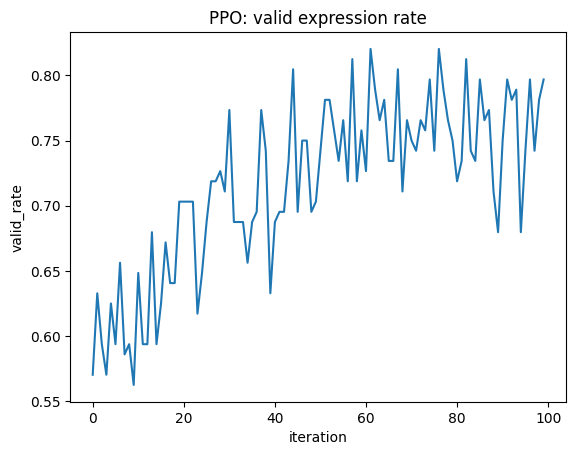

In [47]:
# Plot valid rate over time
import matplotlib.pyplot as plt
vals = [d["valid_rate"] for d in logs_hist]
plt.figure()
plt.plot(vals)
plt.xlabel("iteration")
plt.ylabel("valid_rate")
plt.title("PPO: valid expression rate")
plt.show()


In [48]:
# Save / Load checkpoints
ckpt = {
    "policy": policy.state_dict(),
    "grammar": grammar.state_dict(),
    "cfg": dataclasses.asdict(cfg),
}
save_path = "/content/rl_cfg_transformer_ckpt.pt"
torch.save(ckpt, save_path)
print("Saved to", save_path)

# Example load:
# loaded = torch.load(save_path, map_location=device)
# policy.load_state_dict(loaded["policy"])
# grammar.load_state_dict(loaded["grammar"])


Saved to /content/rl_cfg_transformer_ckpt.pt
